# Task 1

In [1]:
#importing basic libs
import matplotlib.pyplot as plt
import math
import pandas as pd
import numpy as np

#import libs for scraping
from bs4 import BeautifulSoup as bs
import requests
import re

#from pymongo import MongoClient

#import libs for diagnostics
import time
from IPython.display import clear_output

#importing libs for clustering
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

#import libs for cleaning and stemming of the descriptions
from nltk.corpus import stopwords
stop_words = set(stopwords.words("italian"))
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('italian')
import math

#importling libs for the wordcloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#importing our functions file
import functions

## Defining our Functions

You can find all of our functions in the functions.py. 
This way we want to increase the readability of our notebook. We could reuse some functions from the earlier homeworks, e.g. for the calculation/creation of the TfIdf matrix.

## Scraping our data
In a first step we crawled the pages with the search results in order to retrieve the link and the attributes of the appartments we had to collect. Then we passed all the links we found to the function to scrape the descriptions. This way we got a consistent data frame with all information we need. Earlier we tried to first scrape the attributes and links for the listsings found on every page of the search result. The second step was then to get the descriptions out of the pages for the appartement. Unfortunately we could'nt find all descriptions as the pages were taken offline. Because of this we decided to rewrite our code a bit in order to get everything at the same time.

We also decided to scrape more than 10000 listings in order to have at least 10000 listings in our dataframe in case we collected duplicates.

In [21]:
data = pd.DataFrame()
i = 1 
#call function with the next page of search results as long as the dataframe does not contain 10200 rows.
while data.shape[0] <= 10200:
    clear_output()
    #setting up the urls to be crawled by our function, starting from page one (as i is defined as 1 befor executing)
    url = "https://www.immobiliare.it/vendita-case/roma/?criterio=rilevanza&pag="+str(i)
    
    #appending the nested list with the lists of details for every apartement to the dataframe
    appendlist = getDetails(url, i)
    
    #checking if the list returnd by our function is not empty.
    if len(appendlist) !=0:
        data = data.append(appendlist)
        
    clear_output()
    #increasing i by one so the next page of search results will be crawled
    i+=1
    #setting  timer so our requests won't get blocked
    data.to_csv('df.csv', sep='\t')
    time.sleep(2)




Loading the saved csv file with our data

In [2]:
data = pd.read_csv('df.csv', sep='\t')

In the next step we cleaned our dataframe of duplicates and lines that contained NaN instead of values.

In [149]:
data = data.drop_duplicates(subset=None, keep='first')
data = data.dropna()

In order to prepare our data to be used for the calculation of the k-means++, we had to do some changes on the dataframe.

We removed the € signs in the column that contain the prices. We also dropped the lines that contained "SU" instead of prices and the converted it to numeric values.

Then, we changed the values of the number of rooms to integers and replaced "5+" with "6". By changing the value of "5+" to "6" we want to indicate a higher number of rooms so we don't lose these rows for the clustering. 

As before we changed the values in the column for the "bagni" to integer and replaced "3+" with four for the same reason we already explained.

For the values in our "piano" columns, we also changed them in order to get numerical values. The letters we tried to replace in a logical way. "0" indicating "T" (terra), "-1" for "S" (sotterraneo),"12" instead of "A" (attico) and "0.5" for "R" (rialzato).

In [ ]:
data['1'] = data['1'].replace({'\.':'','\€':''}, regex = True)
data['1'] = data['1'][data['1'] != 'SU']
data['1'] = pd.to_numeric(data['1'])
data['2'] = data['2'].map({'1': 1, '2':2, '3':3, '4': 4, '5':5, '5+':6})
data['3'] = pd.to_numeric(data['3'])
data['4'] = data['4'].map({'1': 1, '2':2, '3':3, '3+': 4})
data['5'] = data['5'].map({'1': 1, '2':2, '3':3, '4': 4, '5':5, '6':6, '7':7, '8':8, '9':9, '10':10, '11+':11, 'T': 0, 'S': -1, 'A': 12, 'R': 0.5})    

Resetting the index of our dataframe.

In [151]:
data = data.reset_index(drop=True)

Checking the size of our cleaned dataset.

In [152]:
data.shape[0]

10055

Saving our cleaned dataset.

In [153]:
dfToCsv(data, 'df-clean')

Retrieving only the values from our cleand dataset we need for the first matrix. The resulting matrix will have the format $m_{i,j}=value$, where $i \in \{announcement_1, ..., announcement_n\}$ and $j \in \{prezzo, locali, superficie, bagni, piano \}$.

In [3]:
matrix1 = data[['1', '2', '3', '4', '5']].copy()

Converting the dataframe of values to an array that we can use for the clustering.

In [4]:
#convert to array
matrix1_array = matrix1.values

Creating dictionaries for term Id and the inverse index using the function _"TermDictionaries"_ created in functions.py. We will use them to calculate the TfIdf-values. The first dictionary contains all the words that appear in the announcement descriptions and assigns them an identification key; in the second one instead, at each term id is associated the list of announcements that contains the word.

In [19]:
Term_Id,Inv_Dict = TermDictionaries(data.loc[:,'6'])

In [20]:
saveVocabulary(Term_Id,fileName='Term_Id.csv')

In [22]:
saveVocabulary(Inv_Dict,fileName='Inv_Dict.csv')

Creating the matrix that contains the TfIdf of all the words in the different announcements using the functions in our functions.py file and the dictionaries just created. The resulting matrix will have the format $m_{i,j}=TfIdf_{i,j}$, where $i \in \{announcement_1, ..., announcement_n\}$ and $j \in \{word_1, ..., word_m\}$.

In [ ]:
matrix = pd.DataFrame()
num = 0
for i in data.loc[:,'6']:
    col = []
    app = cleanData(i, lang='italian')        
    score = []
    for word in Term_Id.keys():
        if len(Inv_Dict[Term_Id[word]])>1 and len(Inv_Dict[Term_Id[word]])<10000:
            TfIdf = Tf(word,app)*Idf(word,Inv_Dict,Term_Id,data)
            score.append(TfIdf)
            col.append(Term_Id[word])
    interest = pd.DataFrame([score],columns=col)
    matrix = pd.concat([matrix,interest])
    num += 1
matrix = matrix.reset_index(drop=True)

Saving the tfidf matrix to file so we can easily retrieve our results later.

In [36]:
dfToCsv(matrix, 'TfIdf')

## Calculation kmeans for matrix 1

Finding the number of clusters for matrix 1 using the elbow method, checking for a range of clusters from 1 to 30.

In [174]:
Sum_of_squared_distances = []
K = range(1,31)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(matrix1)
    Sum_of_squared_distances.append(km.inertia_)

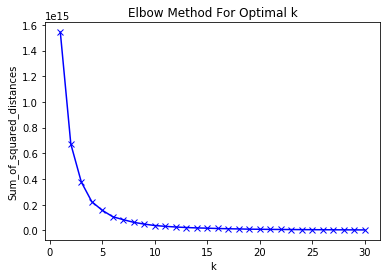

In [176]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Clustering the first matrix: as can be seen in the plot above the elbow is at four, so we will pass this value to the k-means function to create the four clusters. 

In [5]:
kmeans = KMeans(n_clusters=4,init='k-means++', random_state=0).fit(matrix1_array)
kmeansl1 = kmeans.labels_


Assigning the clusters we found for the first matrix to a new column in our original dataframe. This way we can easily retrieve to which cluster every listing belongs and saving the centroids for the comparison with our own k-means function

In [6]:
data['mat1_c'] = kmeansl1
km_plus_cent = kmeans.cluster_centers_

Creating a dictionary for this first clustering to easily compare the different groups: at each cluster (keys of the dictionary) corresponds the list of announcements that it contains.

In [21]:
cluster1={'0':[],'1':[],'2':[],'3':[]}
for i in range(matrix1.shape[0]):
    cluster1[str(data.mat1_c[i])].append(i)

## Calculation kmeans for matrix 2

Reading the file of the TfIdf matrix and converting it to an array.

In [14]:
matrix2 = pd.read_csv('TfIdf.csv', sep='\t')

We had to remove the number we assigned to the entries.

In [17]:
matrix2 = matrix2.iloc[:,1:matrix2.shape[1]]

In [18]:
matrix2_array = matrix2.values

We searched for the ideal number of clusters for the second matrix in a range from 1 to 30. This because a larger number of clusters would be useless as it would create very sparse groups. 

In [44]:
Sum_of_squared_distances2 = []
K = range(1,31)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(matrix2_array)
    Sum_of_squared_distances2.append(km.inertia_)


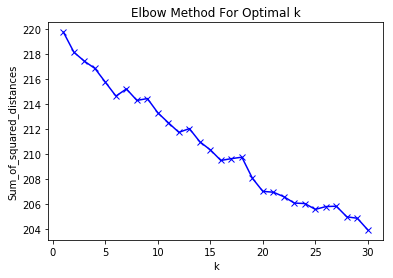

In [45]:
plt.plot(K, Sum_of_squared_distances2, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

As we couldn't find an elbow in the plot above it seemed logical to us to use the same number of clusters used before for the second matrix as well, to better compare the two classifications.

In [19]:
kmeans = KMeans(n_clusters=4,init='k-means++', random_state=0).fit(matrix2_array)
kmeansl2 = kmeans.labels_


Assigning the clusters we found for the second matrix to a new column in our original dataframe and saving the centroids for comparison.

In [21]:
data['mat2_c'] = kmeansl2
km_plus_cent_mat2 = kmeans.cluster_centers_
#dfToCsv(data, 'df_clean_clust')

Creating the dictionary with the different clusters of the second matrix to easily get the announcements belonging to every group.

In [22]:
cluster2={'0':[],'1':[],'2':[],'3':[]}
for i in range(matrix2.shape[0]):
    cluster2[str(data.mat2_c[i])].append(i)

Preparation for the plotting of a bar chart to compare the outcomes of our clustering. 

In [ ]:
cl0m1 = data.mat1_c[data.mat1_c == 0].count()
cl1m1 = data.mat1_c[data.mat1_c == 1].count()
cl2m1 = data.mat1_c[data.mat1_c == 2].count()
cl3m1 = data.mat1_c[data.mat1_c == 3].count()
cl0m2 = data.mat1_c[data.mat2_c == 0].count()
cl1m2 = data.mat1_c[data.mat2_c == 1].count()
cl2m2 = data.mat1_c[data.mat2_c == 2].count()
cl3m2 = data.mat1_c[data.mat2_c == 3].count()

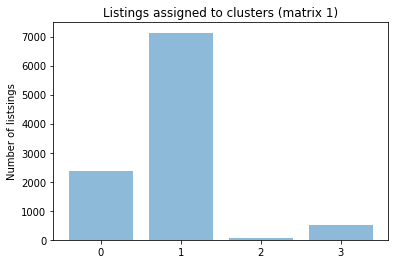

In [19]:
objects = ('0', '1', '2', '3')
y_pos = np.arange(len(clusters1))
clusters1 = [cl0m1,cl1m1,cl2m1,cl3m1]
 
plt.bar(y_pos, clusters1, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Number of listsings')
plt.title('Listings assigned to clusters (matrix 1)')
 
plt.show()

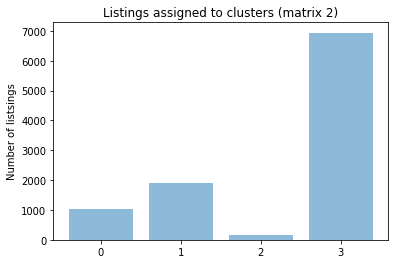

In [15]:
clusters2 = [cl0m2,cl1m2,cl2m2,cl3m2]
 
plt.bar(y_pos, clusters2, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Number of listsings')
plt.title('Listings assigned to clusters (matrix 2)')
 
plt.show()

The number of listings assinged to a cluster differs a bit, as can be seen in the plots above. This is mostly the case for the smaller clusters and the difference doesn't seem to be very big. So we can confirm that the both datasets lead to similar clusters. 

## Calculating the Jaccard Similarity to compare the clusters

Calculating the Jaccard Similarity between each possible couple of clusters ($i$,$j$), where $i$ is a cluster of the first matrix and $j$ one of the second one, using the function we defined in functions.py.

In [25]:
Jaccard_sim = pd.DataFrame()
col = ["cluster 1st matrix", "cluster 2nd matrix", "Jaccard"]
for i in range(len(cluster1.keys())):
    for j in range(len(cluster2.keys())):
        x=compute_jaccard(cluster1[str(i)], cluster2[str(j)])
        score=[str(i), str(j), x]
        interest = pd.DataFrame([score],columns=col)
        Jaccard_sim = pd.concat([Jaccard_sim,interest])

Jaccard_sim= Jaccard_sim.reset_index(drop=True)

 Printing the three most similar couples of clusters.

In [27]:
Jaccard_sim.sort_values("Jaccard", ascending=False)[:3]

,cluster 1st matrix,cluster 2nd matrix,Jaccard
7,1,3,0.517799
3,0,3,0.221332
5,1,1,0.200558


The cluster "**1**" of the first matrix and the cluster "**3**" of the second one are the most similar groups with a quite high value of _Jaccard Similarity_. After this couple the level of analogy strongly decrease: the second and the third most similar couples have a similarity value smaller than the half of the first one. 

Saving our results for  the Jaccard Similarity to file.

In [49]:
dfToCsv(Jaccard_sim, 'jaccard')

## Creating the word clouds
First step is to read the our dataframe that contains all the descriptions and the clusters we found for every announcement/description.

In [48]:
data = pd.read_csv('df_clean_clust.csv', sep='\t')

Next step is to retrieve all the descriptions and append it to a string we'll use later for the word cloud. We use the columns that contain the number of the clusters we found for the announcement using k-means++. This way we can get a variable that contains the pairs of clusters that are the most similar according to the results of our calculation of the Jaccard Similarity.

In [32]:
text_c1 = ''
text_c2 = ''
text_c3 = ''

for index, row in data.iterrows():
    if data.mat1_c[index] == 1 and data.mat2_c[index] == 3:
        text_c1 = text_c1 + data['6'][index]
    if data.mat1_c[index] == 0 and data.mat2_c[index] == 3:
        text_c2 = text_c2 + data['6'][index]
    if data.mat1_c[index] == 1 and data.mat2_c[index] == 1:
        text_c3 = text_c3 + data['6'][index]

Cleaning the text retrieved in the cell above using the modified cleaning function. 

In [33]:
text_c1 = cleanDataWc(text_c1)
text_c2 = cleanDataWc(text_c2)
text_c3 = cleanDataWc(text_c3)

Printing the word clouds with the text for the cluster pairs we retrieved earlier.

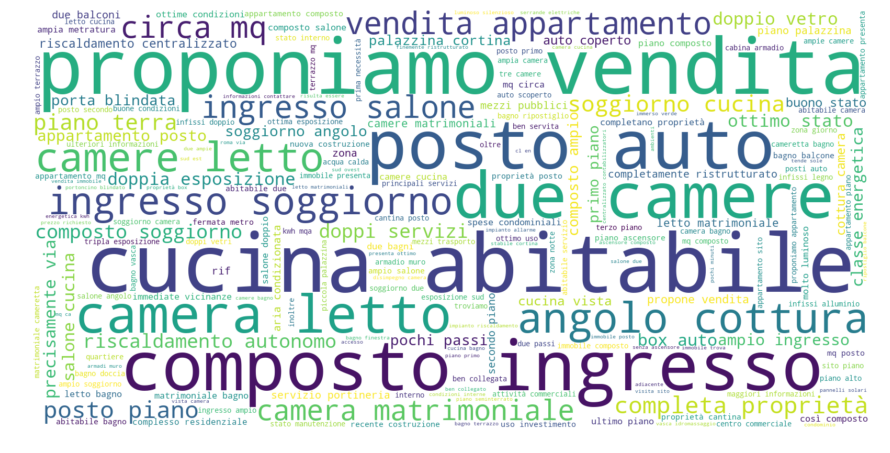

In [43]:
plt.figure(figsize=(15,8))
wordcloud1 = WordCloud(background_color="white",width=1600, height=800).generate(' '.join(text_c1))
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

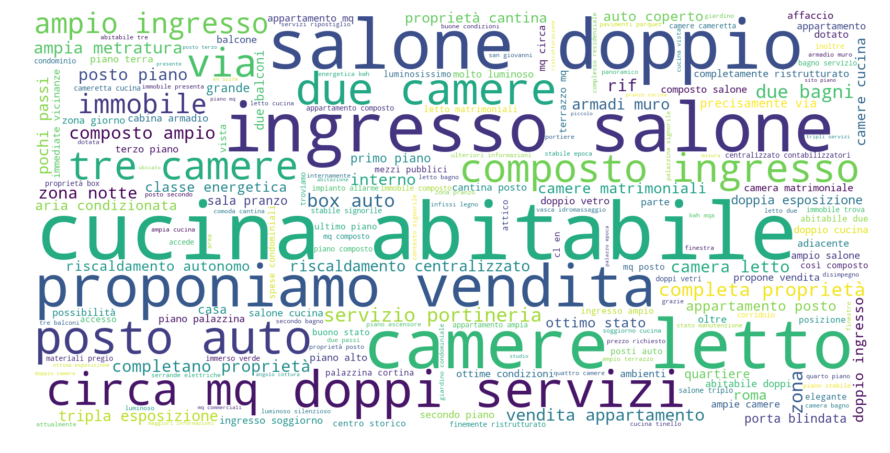

In [44]:
plt.figure(figsize=(15,8))
wordcloud2 = WordCloud(background_color="white",width=1600, height=800).generate(' '.join(text_c2))
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

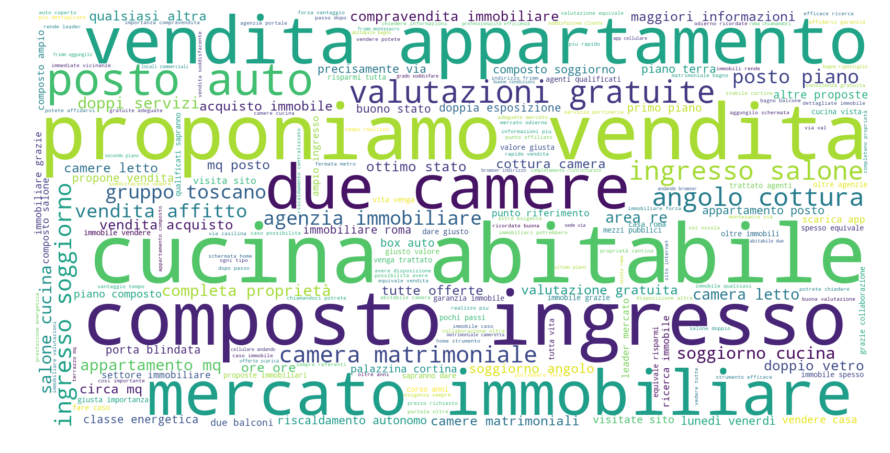

In [45]:
plt.figure(figsize=(15,8))
wordcloud3 = WordCloud(background_color="white",width=1600, height=800).generate(' '.join(text_c3))
plt.imshow(wordcloud3, interpolation='bilinear')
plt.axis("off")
plt.show()

As can be seen in our three word clouds, the frequency of words or combinations of words seem to be very similar in all pairs of clusters. This is indicated by the same sice of the fonts for in the word clouds.

## Bonus: using our own k-means function (without map reduce)

In [11]:
own_cl, own_cents = functions.getClusters(matrix1_array, 4, 500)

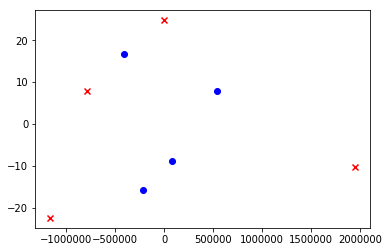

In [13]:
plot = PCA(2)
cl_mat1 = plot.fit_transform(km_plus_cent)
cl_own_mat1 = plot.fit_transform(own_cents)
plt.scatter(cl_mat1[:,0],cl_mat1[:,1],marker='x',c='red',)
plt.scatter(cl_own_mat1[:,0],cl_own_mat1[:,1],marker='o',c='blue',)

As you can see, the centroids our function found (blue dots) differ from the k-means++ function of sklearn (red x's). This might be because we ran only for 500 iterations or some incorrect code. 

## Task 2

In [19]:
import hashlib
import random
from itertools import islice
import fileinput
import functools
import pickle

In [20]:
size = 5000000
truth_d = {}
hash_d = {}
hash_d2 = {}
idx = 0
start = 0

In [21]:
truth_d, hash_d, hash_d2, idx = functions.create_hash_file_and_dict(truth_d, hash_d,hash_d2, "passwords_hash1","passwords_hash2","passwords_hash1_"+str(1),"passwords_hash2_"+str(1), start, start+size,idx)
start = start+size

In [22]:
truth_d, hash_d, hash_d2, idx = functions.create_hash_file_and_dict(truth_d, hash_d,hash_d2, "passwords_hash1","passwords_hash2","passwords_hash1_"+str(2),"passwords_hash2_"+str(2), start, start+size,idx)
start = start+size

In [23]:
truth_d, hash_d, hash_d2, idx = functions.create_hash_file_and_dict(truth_d, hash_d,hash_d2, "passwords_hash1","passwords_hash2","passwords_hash1_"+str(3),"passwords_hash2_"+str(3), start, start+size,idx)
start = start+size

In [24]:
truth_d, hash_d, hash_d2, idx = functions.create_hash_file_and_dict(truth_d, hash_d,hash_d2, "passwords_hash1","passwords_hash2","passwords_hash1_"+str(3),"passwords_hash2_"+str(3), start, start+size,idx)
start = start+size

In [25]:
truth_d, hash_d, hash_d2, idx = functions.create_hash_file_and_dict(truth_d, hash_d,hash_d2, "passwords_hash1","passwords_hash2","passwords_hash1_"+str(4),"passwords_hash2_"+str(4), start, start+size,idx)
start = start+size

In [26]:
truth_d, hash_d, hash_d2, idx = functions.create_hash_file_and_dict(truth_d, hash_d,hash_d2, "passwords_hash1","passwords_hash2","passwords_hash1_"+str(5),"passwords_hash2_"+str(5), start, start+size,idx)
start = start+size

In [27]:
truth_d, hash_d, hash_d2, idx = functions.create_hash_file_and_dict(truth_d, hash_d,hash_d2, "passwords_hash1","passwords_hash2","passwords_hash1_"+str(6),"passwords_hash2_"+str(6), start, start+size,idx)
start = start+size

In [28]:
truth_d, hash_d, hash_d2, idx = functions.create_hash_file_and_dict(truth_d, hash_d,hash_d2, "passwords_hash1","passwords_hash2","passwords_hash1_"+str(7),"passwords_hash2_"+str(7), start, start+size,idx)
start = start+size

In [29]:
truth_d, hash_d, hash_d2, idx = functions.create_hash_file_and_dict(truth_d, hash_d,hash_d2, "passwords_hash1","passwords_hash2","passwords_hash1_"+str(8),"passwords_hash2_"+str(8), start, start+size,idx)
start = start+size

In [30]:
truth_d, hash_d, hash_d2, idx = functions.create_hash_file_and_dict(truth_d, hash_d,hash_d2, "passwords_hash1","passwords_hash2","passwords_hash1_"+str(9),"passwords_hash2_"+str(9), start, start+size,idx)
start = start+size

In [31]:
truth_d, hash_d, hash_d2, idx = functions.create_hash_file_and_dict(truth_d, hash_d,hash_d2, "passwords_hash1","passwords_hash2","passwords_hash1_"+str(10),"passwords_hash2_"+str(10), start, start+size,idx)
start = start+size

In [32]:
truth_d, hash_d, hash_d2, idx = functions.create_hash_file_and_dict(truth_d, hash_d,hash_d2, "passwords_hash1","passwords_hash2","passwords_hash1_"+str(11),"passwords_hash2_"+str(11), start, start+size,idx)
start = start+size

In [33]:
truth_d, hash_d, hash_d2, idx = functions.create_hash_file_and_dict(truth_d, hash_d,hash_d2, "passwords_hash1","passwords_hash2","passwords_hash1_"+str(12),"passwords_hash2_"+str(12), start, start+size,idx)
start = start+size

In [34]:
truth_d, hash_d, hash_d2, idx = functions.create_hash_file_and_dict(truth_d, hash_d,hash_d2, "passwords_hash1","passwords_hash2","passwords_hash1_"+str(13),"passwords_hash2_"+str(13), start, start+size,idx)
start = start+size

In [35]:
truth_d, hash_d, hash_d2, idx = functions.create_hash_file_and_dict(truth_d, hash_d,hash_d2, "passwords_hash1","passwords_hash2","passwords_hash1_"+str(14),"passwords_hash2_"+str(14), start, start+size,idx)
start = start+size

In [36]:
truth_d, hash_d, hash_d2, idx = functions.create_hash_file_and_dict(truth_d, hash_d,hash_d2, "passwords_hash1","passwords_hash2","passwords_hash1_"+str(15),"passwords_hash2_"+str(15), start, start+size,idx)
start = start+size

In [43]:
truth_d, hash_d, hash_d2, idx = functions.create_hash_file_and_dict(truth_d, hash_d,hash_d2, "passwords_hash1","passwords_hash2","passwords_hash1_"+str(16),"passwords_hash2_"+str(16), start, start+size,idx)
start = start+size

In [44]:
truth_d, hash_d, hash_d2, idx = functions.create_hash_file_and_dict(truth_d, hash_d,hash_d2, "passwords_hash1","passwords_hash2","passwords_hash1_"+str(17),"passwords_hash2_"+str(17), start, start+size,idx)
start = start+size

In [45]:
truth_d, hash_d, hash_d2, idx = functions.create_hash_file_and_dict(truth_d, hash_d,hash_d2, "passwords_hash1","passwords_hash2","passwords_hash1_"+str(18),"passwords_hash2_"+str(18), start, start+size,idx)
start = start+size

In [46]:
truth_d, hash_d, hash_d2, idx = functions.create_hash_file_and_dict(truth_d, hash_d,hash_d2, "passwords_hash1","passwords_hash2","passwords_hash1_"+str(19),"passwords_hash2_"+str(19), start, start+size,idx)
start = start+size

In [47]:
truth_d, hash_d, hash_d2, idx = functions.create_hash_file_and_dict(truth_d, hash_d,hash_d2, "passwords_hash1","passwords_hash2","passwords_hash1_"+str(20),"passwords_hash2_"+str(20), start, start+size,idx)
start = start+size

In [48]:
truth_d, hash_d, hash_d2, idx = functions.create_hash_file_and_dict(truth_d, hash_d,hash_d2, "passwords_hash1","passwords_hash2","passwords_hash1_"+str(21),"passwords_hash2_"+str(21), start, start+size,idx)
start = start+size

In [49]:
truth_d, hash_d, hash_d2, idx = functions.create_hash_file_and_dict(truth_d, hash_d,hash_d2, "passwords_hash1","passwords_hash2","passwords_hash1_"+str(22),"passwords_hash2_"+str(22), start, start+size,idx)
start = start+size

#### Find if two numbers fall in the same range 

In [53]:
functions.same_range(hash_d, "passwords_hash1.txt")
functions.same_range(hash_d2, "passwords_hash2.txt")

1277  and  1671  are not in the same range
9856975612261844412011546508811955761088611763371  and  8832661167611481633339606810480102117781185097481  are not in the same range


In [54]:
functions.find_dup()

10000000


In [59]:
functions.false_positives(hash_d)

28419480


In [60]:
functions.false_positives2(hash_d2)

4790220


The first hash function contains more false positive just because it's easier to find strings duplicates when the string themselves are alphabetically ordered; consequently, this increase the probability to find equal strings then, same hashes are created. 

In [61]:
save_obj(truth_d, "truth_d")
save_obj(hash_d, "hash_d")
save_obj(hash_d2, "hash_d2")

In [62]:
del truth_d
del hash_d
del hash_d2